# **Import needed libraries**

In [1]:
!pip install tensorflow

In [2]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')
# **Loading the dataset**



In [3]:
import os
import pandas as pd
# Generate data paths with labels
train_data_dir = "Training"

filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


> read the testing dataset into the dataframe

In [5]:
# Generate data paths with labels
train_data_dir = "Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
ts_df

,filepaths,labels
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


# **Data preprocessing**

first we will check if the training data is balanced or not

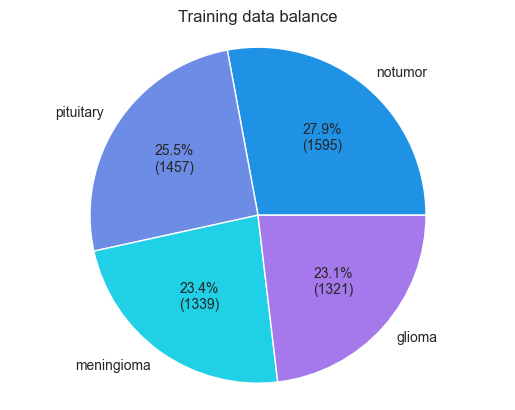

In [7]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

**data is balanced.**

**now we will split the testing data to test and validation data**

In [8]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

**Create image data generator**

this step to convert these dataframes to numpy array

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


**Display sample from train data**

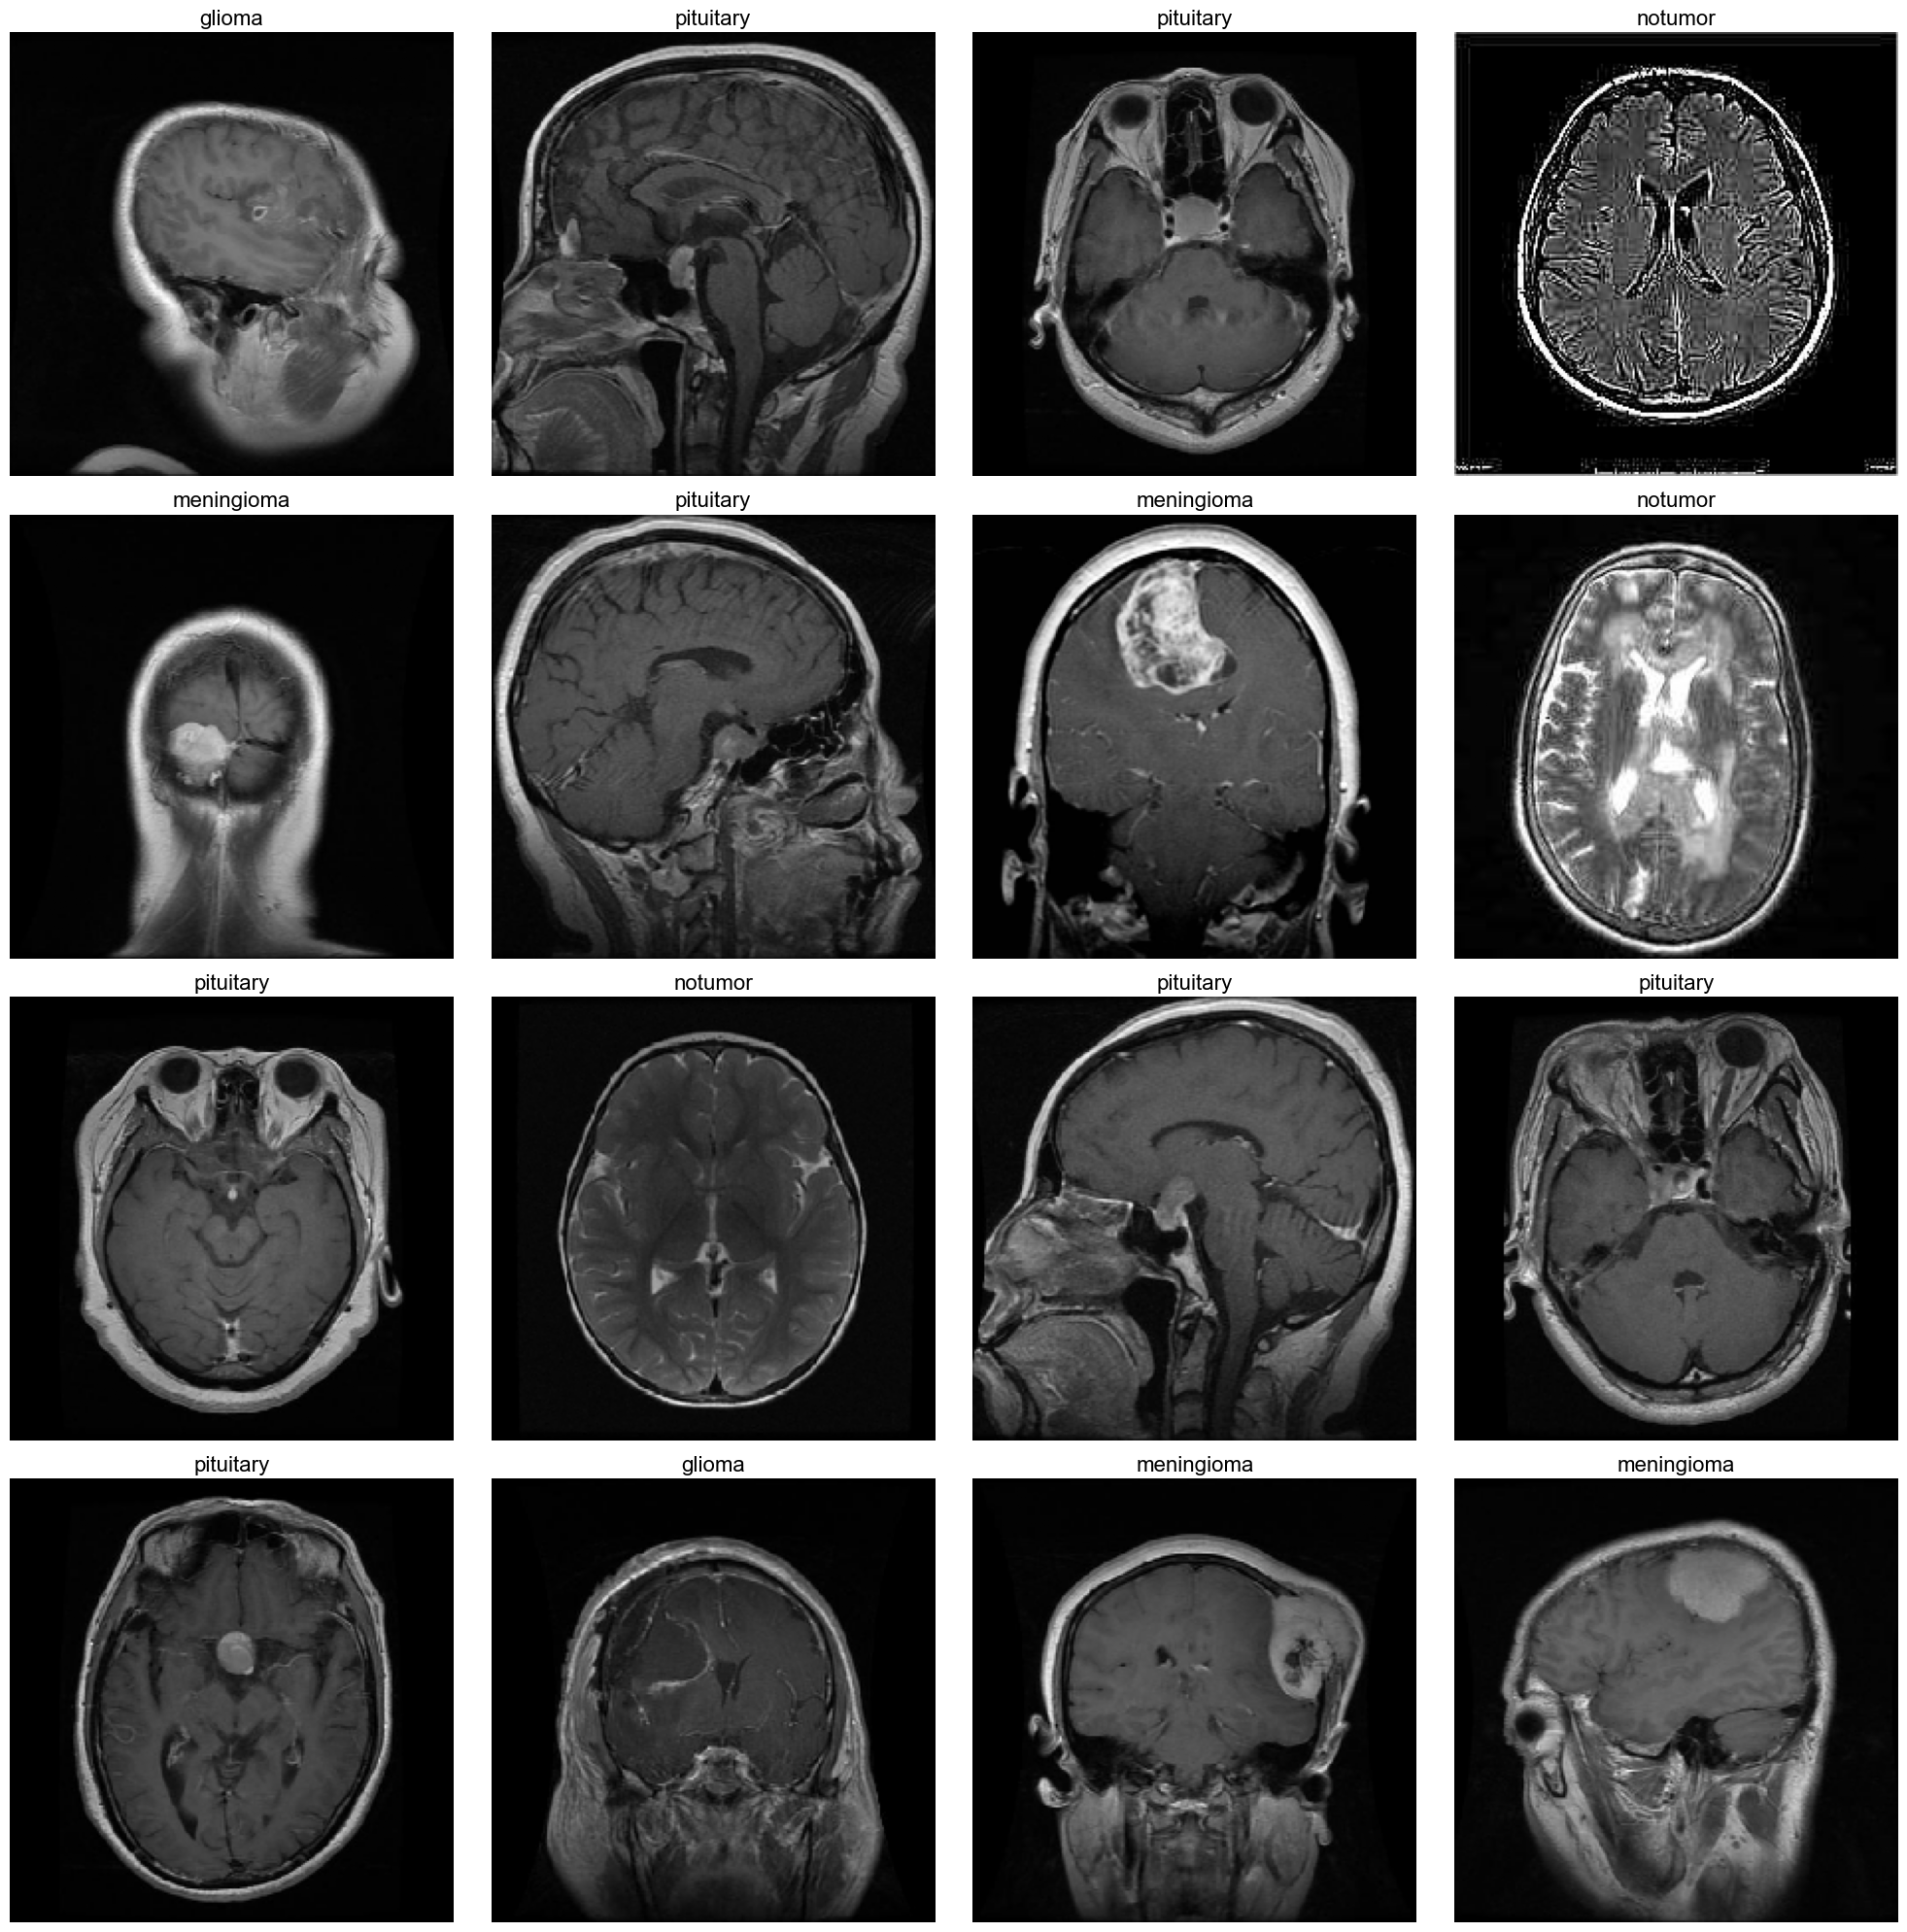

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))


In [12]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 299s 818ms/step - accuracy: 0.6208 - loss: 48.7919 - val_accuracy: 0.9527 - val_loss: 0.1846
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 325s 910ms/step - accuracy: 0.9592 - loss: 0.1317 - val_accuracy: 0.9909 - val_loss: 0.0479
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 344s 964ms/step - accuracy: 0.9903 - loss: 0.0447 - val_accuracy: 0.9982 - val_loss: 0.0219
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 273s 764ms/step - accuracy: 0.9984 - loss: 0.0166 - val_accuracy: 0.9979 - val_loss: 0.0179
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 259s 724ms/step - accuracy: 0.9991 - loss: 0.0087 - val_accuracy: 0.9975 - val_loss: 0.0128
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 283s 792ms/step - accuracy: 0.9994 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 267s 748ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 4.7638e-04
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 237s 664ms/step - accuracy: 1.0

**Display model performance**

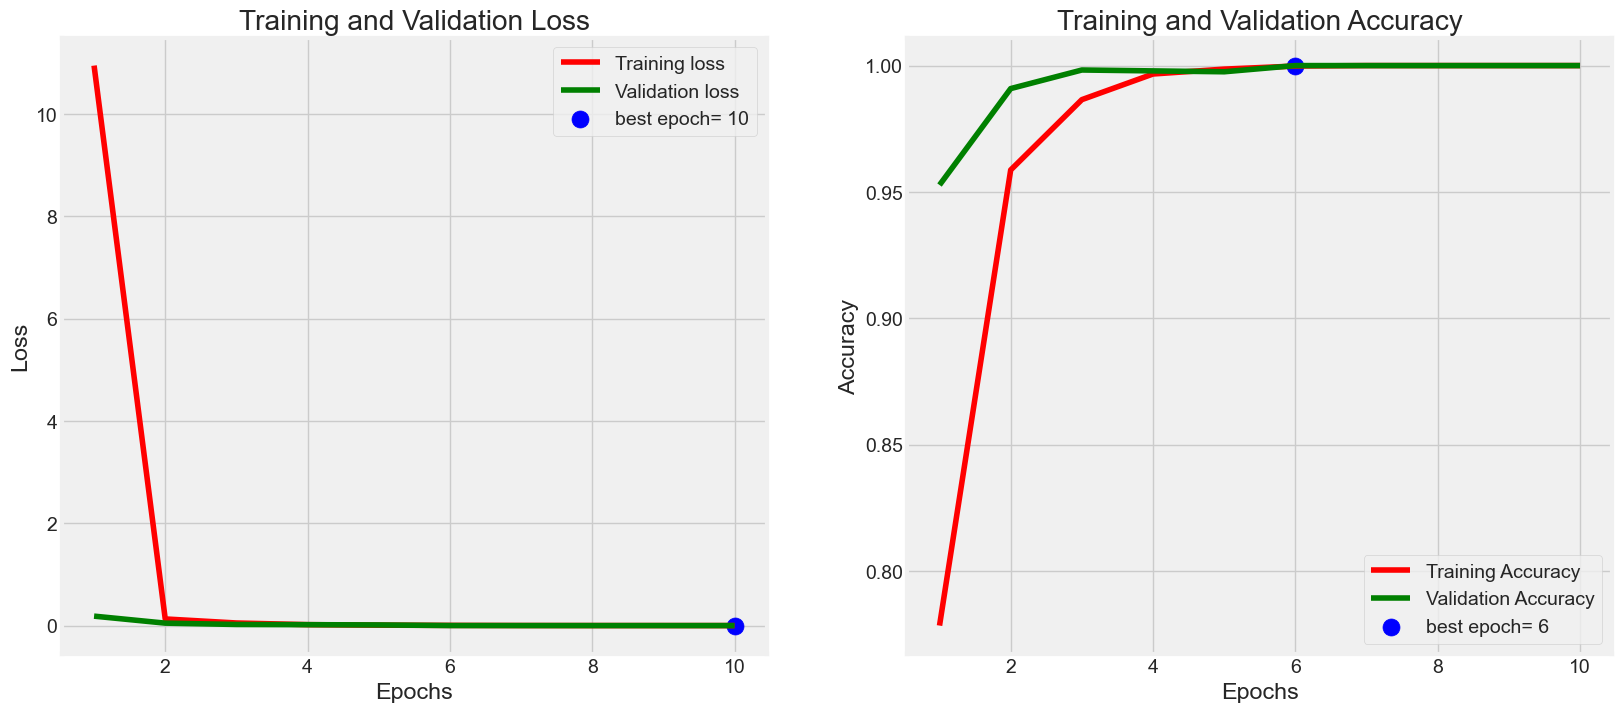

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [15]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - accuracy: 1.0000 - loss: 9.0948e-05
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 1.0000 - loss: 8.1954e-05
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 1.0000 - loss: 8.6988e-05
Train Loss:  8.476799121126533e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  8.547930337954313e-05
Validation Accuracy:  1.0
--------------------
Test Loss:  8.405662083532661e-05
Test Accuracy:  1.0


# **Get Predictions**

In [16]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step


**Confusion Matrics and Classification Report**

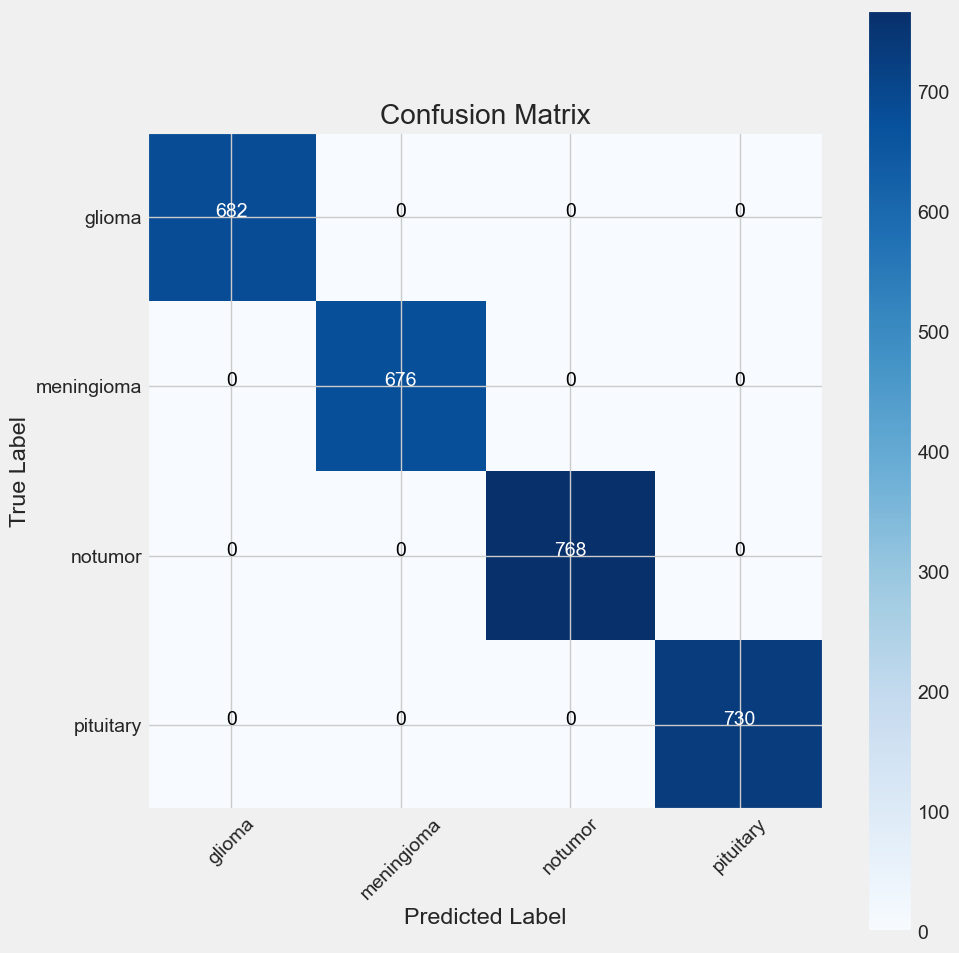

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       682
  meningioma       1.00      1.00      1.00       676
     notumor       1.00      1.00      1.00       768
   pituitary       1.00      1.00      1.00       730

    accuracy                           1.00      2856
   macro avg       1.00      1.00      1.00      2856
weighted avg       1.00      1.00      1.00      2856



In [19]:
#Save the model
model.save('Brain Tumor.h5')